In [1]:
import cv2
import numpy as np 
import pandas as pd
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pickle
import datetime

### FrameProcessing Class

This class is responsible for methods that will process each frame, such as the one that converts the image to its grayscale and the method that will extract the keypoints and process its descriptors

In [2]:
class FrameProcessing:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return descriptors

In [3]:
def fileProcess(path):
    fp = FrameProcessing()
    descriptorsList = []
    labels = []
    for each in glob(path + "*"):
        word = each.split("/")[-1]
        for videoFolder in glob(path+word+"/*"):
            video = videoFolder.split("/")[-1]
            for imagefile in glob(path + word + "/" + video + "/*.jpg"):
                #Read image
                im = cv2.imread(imagefile, 0)
                #Compute features
                descriptorsList.append(fp.features(im))
                # Create list of labels
                labels.append(word)
    return (descriptorsList, labels)

### Vocabulary Class

This class will generate a visual word vocabulary, based on training images that are provide to a K-Means algorithm, so it will cluster similar features into one

In [19]:
class VocabularyCreator:
    def __init__(self, codebook_size=20, normalize=True):
        # KMeans attributes
        self.kmeans_obj = KMeans(n_clusters=codebook_size)
        self.codebook_size = codebook_size
        self.__kmeans_ret = None
        self.__vocabulary = None
        self.__scale = None
        self.idList = None
        self.__normalize = normalize
    
    def fit(self, X):
        print("Performing clustering")
        self.__kmeans_ret = self.kmeans_obj.fit_predict(X)

    def createVocabulary(self, X):
        """
        Each cluster denotes a particular visual word
        Every image can be represeted as a combination of multiple
        visual words. The best method is to generate a sparse histogram
        that contains the frequency of occurence of each visual word

        Thus the vocabulary comprises of a set of histograms of encompassing
        all descriptions for all images
        """
                
        #Clustering the list
        self.fit(np.vstack(X))
        
        self.idList = np.concatenate([[id]*len(sublist) for id, sublist in enumerate(X)])
        self.X = []
        
        print('Creating histograms')
        for id in np.unique(self.idList):
            bincount = np.zeros(self.codebook_size)
            aux_bincount = np.bincount(self.__kmeans_ret[self.idList == id])
            bincount[:len(aux_bincount)] = aux_bincount
            self.X.append(bincount)
        self.X = np.vstack(self.X)
        
        #Standardizing the histogram
        if (self.__normalize):
            self.standardize()
                
    def standardize(self, std=None):
        """
        standardize is required to normalize the distribution
        wrt sample size and features. If not normalized, the classifier may become
        biased due to steep variances.
        """
        if std is None:
            self.__scale = StandardScaler().fit(self.X)
            self.X = self.__scale.transform(self.X)
        else:
            print("STD not none. External STD supplied")
            self.__vocabulary = std.transform(self.__vocabulary)
        
    def plotHist(self):
        pd.Series(self.__kmeans_ret).value_counts().sort_index().plot(kind='bar')
    
    def getVocabulary(self):
        return self.X

In [5]:
def saveObject(data, filename):
    pickle.dump(data, open(filename, 'wb'))

### SIFT

This part of code will be responsible for getting all images from dataset, putting it in a dictionary and computing descriptors for each image. These descriptors will then be put in an array, so as to use it on kmeans algorithm

In [6]:
path = "/home/fabiana/Desktop/projeto-final-src/datasets/HandGesture_PreProcessed/"
x_kmeans, y = fileProcess(path)

Saving labels to use in SVM training

In [7]:
now = datetime.datetime.now()

In [8]:
date = str(now.year) + "_" + str(now.month) + "_" + str(now.day)

In [9]:
saveObject(y, date + "_labels.pkl")

### Codebook creation

In [10]:
codebook_size = [110, 220, 440, 880, 1650, 2200, 3300, 3850, 4400]

In [11]:
for size in codebook_size:
    print("Creating vocabulary of size " + str(size))
    vocabulary = VocabularyCreator(codebook_size=size)
    vocabulary.createVocabulary(x_kmeans)
    saveObject(vocabulary.X, "vocabulary_" + str(size) + "_" + date + "_input.pkl")
    saveObject(vocabulary.kmeans_obj, "vocabulary_" + str(size) + "_" + date + "_kmeans.pkl")

Creating vocabulary of size 110
Performing clustering
Creating histograms
Creating vocabulary of size 220
Performing clustering
Creating histograms
Creating vocabulary of size 440
Performing clustering
Creating histograms
Creating vocabulary of size 880
Performing clustering


MemoryError: Unable to allocate array with shape (1264686, 880) and data type float32

In [196]:
inputClf = open("vocabulary_440_2019_12_16_input.pkl",'rb')
targetClf = open("2019_12_16_labels.pkl", 'rb')
X = pickle.load(inputClf)
y = pickle.load(targetClf)
y = np.array(y)

In [197]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import NearestCentroid
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Folds

In [219]:
cv = KFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### SVM

In [220]:
svm = SVC()

In [221]:
grid_cv = GridSearchCV(svm, {'C': [0.2, 0.5, 1]}, scoring='accuracy', n_jobs=-1, cv=cv)
grid_cv.fit(X_train, y_train)
grid_cv.cv_results_
grid_cv.best_params_

/home/fabiana/miniconda3/envs/opencv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'C': 1}

In [222]:
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

/home/fabiana/miniconda3/envs/opencv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5458715596330275

### Nearest Neighbors

In [227]:
nn = neighbors.KNeighborsClassifier(15, weights='distance')

In [228]:
grid_cv = GridSearchCV(nn, {'n_neighbors': [2, 3, 4, 5], 'weights':['distance', 'uniform']}, scoring='accuracy', n_jobs=-1, cv=cv)
grid_cv.fit(X_train, y_train)
grid_cv.cv_results_
grid_cv.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

In [229]:
nn = nn.fit(X_train, y_train)
nn.score(X_test, y_test)

0.7545871559633027

In [195]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(2)

In [40]:
tsne_features = tsne.fit_transform(X)

In [41]:
df_tsne = pd.DataFrame({
    'feature0': tsne_features[:,0],
    'feature1': tsne_features[:,1]}
)
df_tsne['label'] = y

In [42]:
cmap = plt.get_cmap('tab10')

In [43]:
colors = [cmap(int(label))for label in y]

ValueError: invalid literal for int() with base 10: 'NO'

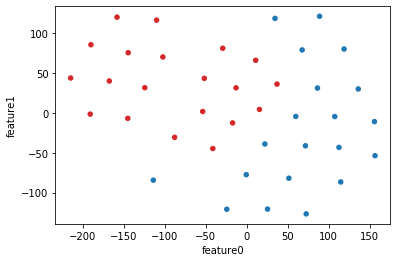

In [144]:
df_tsne.plot(x='feature0', y='feature1', color=colors, kind='scatter')